## Dataset

In [ ]:
%pip install datasets transformers accelerate kagglehub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import requests
import os
import json

from PIL import Image

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset as TorchDataset
from torchvision.transforms import ToTensor
from datasets import Dataset, DatasetDict, load_dataset
from transformers import (
    TrOCRProcessor,
    VisionEncoderDecoderModel,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    default_data_collator,
    DataCollatorForSeq2Seq
)
from torch.nn.utils.rnn import pad_sequence


# GPU
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda")
else:
    print("GPU not available")
    device = torch.device("cpu")

Using GPU: Tesla T4


In [ ]:
import kagglehub

dataset_name = "vpippi/lam-dataset"
path = kagglehub.dataset_download(dataset_name)

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/lam-dataset


In [ ]:
import os

path_to_train_json = f"{path}/LAM/lines/split/basic/train.json"
path_to_test_json = f"{path}/LAM/lines/split/basic/test.json"
path_to_valid_json = f"{path}/LAM/lines/split/basic/val.json"
path_to_images = f"{path}/LAM/lines/img/"

os.path.exists(path_to_train_json) and os.path.exists(path_to_images) and os.path.exists(path_to_test_json) and os.path.exists(path_to_valid_json)

True

In [ ]:
json_train_file = open(path_to_train_json)
json_test_file = open(path_to_test_json)
json_valid_file = open(path_to_valid_json)
json_train_data = json.loads(json_train_file.read())
json_test_data = json.loads(json_test_file.read())
json_valid_data = json.loads(json_valid_file.read())

print("train images: ", len(json_train_data))
print("test images: ", len(json_test_data))
print("validation images: ", len(json_valid_data))

train images:  19830
test images:  3523
validation images:  2470


In [ ]:
json_train_data[:3]

[{'decade_id': 0,
  'height': 130,
  'img': '002_02_00.jpg',
  'nameset': 'train',
  'text': 'Lettera di Lod. Antonio',
  'width': 1120},
 {'decade_id': 0,
  'height': 147,
  'img': '002_02_01.jpg',
  'nameset': 'train',
  'text': 'di Giacomo Bianchi',
  'width': 986},
 {'decade_id': 1,
  'height': 112,
  'img': '002_04_00.jpg',
  'nameset': 'train',
  'text': 'Arona 30. 9bre. 94.',
  'width': 657}]










### dataset statistics

average train line length: 37.54861321230459
average train words per line: 6.752143217347453
average train image size: 669.1109934442763 x 54.044276348966214


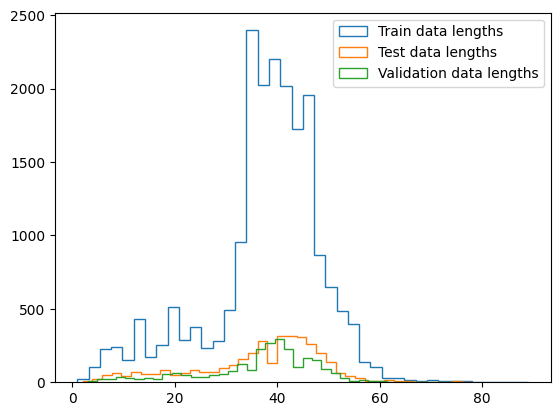

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def avg(split_by_words: bool = False, atrib = "text", data: list = json_train_data):
  if atrib != "text":
    return sum([x[atrib] for x in data]) / len(data)
  elif split_by_words:
    return sum([len(x[atrib].split(' ')) for x in data]) / len(data)
  else:
    return sum([len(x[atrib]) for x in data]) / len(data)

print("average train line length:", avg())
print("average train words per line:", avg(split_by_words=True))
print("average train image size:", avg(atrib="width"), "x", avg(atrib="height"))

plt.hist([len(x["text"]) for x in json_train_data], histtype='step', bins=40, label="Train data lengths")
plt.hist([len(x["text"]) for x in json_test_data], histtype='step', bins=40, label="Test data lengths")
plt.hist([len(x["text"]) for x in json_valid_data], histtype='step', bins=40, label="Validation data lengths")
plt.legend()
plt.show()

## loading model

In [ ]:
%pip install tiktoken sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.2 MB/s eta 0:00:00


In [ ]:
MODEL_TYPE = "small"

if MODEL_TYPE not in ['small', 'base', 'large']:
  raise ValueError(f"Invalid model type: {MODEL_TYPE}")

# small model
processor = TrOCRProcessor.from_pretrained(f"microsoft/trocr-{MODEL_TYPE}-handwritten", use_fast=False)
model = VisionEncoderDecoderModel.from_pretrained(f"microsoft/trocr-{MODEL_TYPE}-handwritten")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/327 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.21k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/246M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.deit.modeling_deit.DeiTModel'> is overwritten by shared encoder config: DeiTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 384,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "model_type": "deit",
  "num_attention_heads": 6,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 384,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.50.2"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 384,
  "d_

generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## Evaluation metrics
WER (words error rate), CER (character error rate)

In [ ]:
%pip install python-Levenshtein evaluate jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 59.2 MB/s eta 0:00:00


In [ ]:
import Levenshtein
import re

# Normalizes the text by converting to lowercase, removing punctuation, and collapsing multiple whitespaces.
def normalize_text(text: str) -> str:
    text = text.lower()
    # remove punctuation and keeps letters, numbers, and whitespace
    text = re.sub(r'[^\w\s]', '', text)
    # collapse multiple whitespace characters into a single space
    text = ' '.join(text.split())
    return text

def calculate_cer(ground_truth: str, prediction: str, normalize: bool = False) -> float:
    if normalize:
        ground_truth = normalize_text(ground_truth)
        prediction = normalize_text(prediction)

    if not ground_truth:
        return 0.0 if not prediction else 1.0

    # number of edits
    distance = Levenshtein.distance(prediction, ground_truth)

    return distance / len(ground_truth)

def calculate_wer(ground_truth: str, prediction: str, normalize: bool = False) -> float:
    if normalize:
        ground_truth = normalize_text(ground_truth)
        prediction = normalize_text(prediction)

    # split strings into words (based on whitespace)
    ground_truth_words = ground_truth.split()
    prediction_words = prediction.split()

    if not ground_truth_words:
       return 0.0 if not prediction_words else 1.0

    # calculate Levenshtein distance at the word level
    distance = Levenshtein.distance(prediction_words, ground_truth_words)

    return distance / len(ground_truth_words)

def calculate_cer_wer(ground_truth: str, prediction: str) -> tuple:
  # calculate WITHOUT normalization
  cer_raw = calculate_cer(ground_truth, prediction)
  wer_raw = calculate_wer(ground_truth, prediction)

  # calculate WITH normalization
  norm_gt = normalize_text(ground_truth)
  norm_pred = normalize_text(prediction)

  cer_norm = calculate_cer(norm_gt, norm_pred)
  wer_norm = calculate_wer(norm_gt, norm_pred)

  print(f"GROUND TRUTH:    '{ground_truth}'")
  print(f"PREDICTION:      '{prediction}'")
  print(f"GT normalized:   '{norm_gt}'")
  print(f"PRED normalized: '{norm_pred}'")
  print()

  # CER & WER
  print(f"Raw CER: {cer_raw:.4f} ({cer_raw*100:.2f}%)")
  print(f"Raw WER: {wer_raw:.4f} ({wer_raw*100:.2f}%)")
  print()

  print(f"Normalized CER: {cer_norm:.4f} ({cer_norm*100:.2f}%)")
  print(f"Normalized WER: {wer_norm:.4f} ({wer_norm*100:.2f}%)")
  print()

  # Accuracy
  print(f"Normalized Character Accuracy: {(1 - cer_norm):.4f} ({(1 - cer_norm)*100:.2f}%)")
  print(f"Normalized Word Accuracy:      {(1 - wer_norm):.4f} ({(1 - wer_norm)*100:.2f}%)")
  print(f"\n{'='*50}\n")

  return (cer_raw, wer_raw), (cer_norm, wer_norm)

# for multiple results given in dictionary
def error_analysis(comparison_dict, normalize=True):
  for label, (gt, pred) in comparison_dict.items():
    print(f"IMAGE: {label}")
    calculate_cer_wer(gt, pred)

# Used for fine-tuning and training
def train_metric(pred):
    print(f"pred: {pred}")
    labels_ids = pred_ids = []
    try:
        labels_ids = pred['label_ids']
        pred_ids = pred['predictions']
    except TypeError:
        labels_ids = pred.label_ids
        pred_ids = pred.predictions
    pred = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    gt = processor.batch_decode(labels_ids, skip_special_tokens=True)

    print(f"{gt}\n{pred}\n")
    cer = calculate_cer(gt, pred)
    print(f"Type of cer: {type(cer)}, Value of cer: {cer}")

    return {"cer": cer}




from evaluate import load
cer_metric = load("cer")

def compute_metrics(pred):
    try:
        labels_ids = pred['label_ids']
        pred_ids = pred['predictions']
    except TypeError:
        labels_ids = pred.label_ids
        pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

testing model inference and accuracy

In [ ]:
#
from IPython.display import display
from ipywidgets.widgets import IntProgress

def test_model(model,
               processor: TrOCRProcessor,
               images_to_test = 5,
               json_data=json_test_data):
  progress_bar = IntProgress(min=0, max=images_to_test, description='Inference:', value=0)
  display(progress_bar)

  comparison_dict = {}

  for item in json_data[0:images_to_test]:
      try:
        image = Image.open(path_to_images + item['img']).convert("RGB")
        display(image)
      except:
        continue
      prediction = processor(image, return_tensors="pt")
      generated_ids = model.generate(prediction.pixel_values)
      generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

      target_text = item['text']

      # counts wrong characters
      print("ground truth: ", target_text)
      print("generated:    ", generated_text)
      print()

      comparison_dict[item['img']] = (target_text, generated_text)
      progress_bar.value += 1

  error_analysis(comparison_dict, normalize=True)

IntProgress(value=0, description='Inference:', max=5)

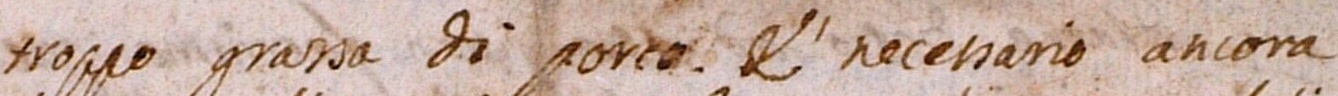

ground truth:  troppo grasso di porco. È necessario ancora
generated:     is a small or a large of the most successful administrative areas of



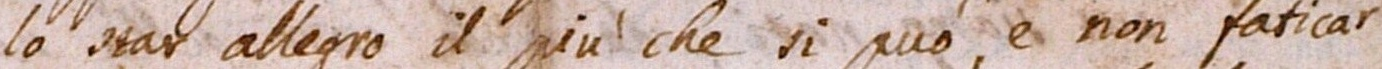

ground truth:  lo star allegro il più che si può, e non faticar
generated:     is a M W. W. A man was said that his first very good relationship to the



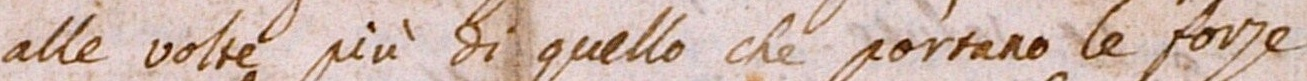

ground truth:  alle volte più di quello che portano le forze
generated:     " It is is a useful to be used to be used by the subject of any



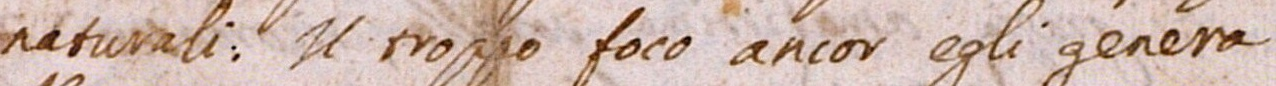

ground truth:  naturali: il troppo poco ancor egli genera
generated:     # # # # Microsoft for the American



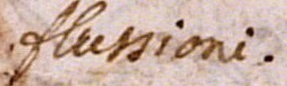

ground truth:  illusioni.
generated:     " Sustainable

IMAGE: 002_07_00.jpg
GROUND TRUTH:    'troppo grasso di porco. È necessario ancora'
PREDICTION:      'is a small or a large of the most successful administrative areas of'
GT normalized:   'troppo grasso di porco è necessario ancora'
PRED normalized: 'is a small or a large of the most successful administrative areas of'

Raw CER: 1.2326 (123.26%)
Raw WER: 1.8571 (185.71%)

Normalized CER: 1.2381 (123.81%)
Normalized WER: 1.8571 (185.71%)

Normalized Character Accuracy: -0.2381 (-23.81%)
Normalized Word Accuracy:      -0.8571 (-85.71%)


IMAGE: 002_07_01.jpg
GROUND TRUTH:    'lo star allegro il più che si può, e non faticar'
PREDICTION:      'is a M W. W. A man was said that his first very good relationship to the'
GT normalized:   'lo star allegro il più che si può e non faticar'
PRED normalized: 'is a m w w a man was said that his first very good relationship to the'

Raw CER: 1.1250 (112.50%)
Raw WER: 1.5455 (154.55%)

Normalize

In [ ]:
test_model(model, processor)

## Fine-tuning
Firstly, check if the vocabulary inclues italian tokens


In [ ]:
vocab = processor.tokenizer.get_vocab()
italian_special_chars = ['à', 'è', 'é', 'ì', 'ò', 'ù', 'À', 'È', 'É', 'Ì', 'Ò', 'Ù']
# check if the vocabulary includes italian characters
for c in italian_special_chars:
    if c not in vocab:
        print(f"'{c}' not in vocab")
    else:
        print(f"'{c}' in vocab as {vocab[c]}")

if not all([char for char in vocab]):
  missing_chars = set(italian_special_chars) - set(vocab.keys())
  print(f"The following Italian characters are missing: {missing_chars}")
  try:
    model.resize_token_embeddings(len(processor.tokenizer)+len(missing_chars))
    processor.tokenizer.add_tokens(missing_chars)
  except Exception as e:
    print(e)

'à' in vocab as 11616
'è' in vocab as 12114
'é' in vocab as 3164
'ì' in vocab as 31120
'ò' in vocab as 25039
'ù' in vocab as 43582
'À' in vocab as 62558
'È' in vocab as 62880
'É' in vocab as 32945
'Ì' in vocab as 63946
'Ò' in vocab as 63478
'Ù' in vocab as 63346


In [ ]:
# setup
LEARNING_RATE = 5e-5
NUM_TRAIN_EPOCHS = 5
BATCH_SIZE = 8
LOGGING_STEPS = 50
SAVE_STEPS = 1000
EVAL_STEPS = 250
OUTPUT_DIR = "./trocr-italian-finetuned"

In [ ]:
def create_hf_dataset(json_data, name):
    # prepare data in the format expected by datasets library
    data_dict = {
        'image_path': [os.path.join(path_to_images, item["img"]) for item in json_data],
        'text': [item["text"] for item in json_data]
    }
    print(f"First few entries for {name} dataset:")
    for i in range(min(3, len(data_dict['image_path']))):
         print(f"\tImage Path: {data_dict['image_path'][i]}, Text: '{data_dict['text'][i]}'")
         if not os.path.exists(data_dict['image_path'][i]):
             print(f"Image file not found: {data_dict['image_path'][i]}")

    return Dataset.from_dict(data_dict)


# preprocessing
def preprocess_data(examples):
    try:
        images = [Image.open(path).convert("RGB") for path in examples['image_path']]
    except FileNotFoundError as e:
         print(f"Preprocessing error: Image file not found - {e}. Check PATH_TO_IMAGES.")

    # process images using the processor's feature extractor
    pixel_values = processor(images=images, return_tensors="pt").pixel_values
    labels = processor.tokenizer(text=examples['text'], padding="max_length", truncation=True).input_ids

    # remove padding tokens from labels
    labels = [[label if label != processor.tokenizer.pad_token_id else -100 for label in instance_labels]
              for instance_labels in labels]

    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
class LAM(torch.utils.data.Dataset):
    def __init__(self,
                 db_path,
                 split,
                 transforms,
                 nameset='train',
                 charset=None,
                 processor=None,
                 max_target_length=64):
        set_path = os.path.join(db_path, 'lines', 'split', split, f'{nameset}.json')
        assert os.path.exists(set_path)

        with open(set_path, 'r') as f:
            self.samples = json.load(f)
        self.transforms = transforms
        self.db_path = db_path
        self.imgs_path = os.path.join(db_path, 'lines', 'img')
        self.processor = processor
        self.max_target_length = max_target_length

        if charset is None:
            labels = [sample['text'] for sample in self.samples]
            charset = sorted(set(''.join(labels)))

        self.charset = charset
        self.char_to_idx = dict(zip(self.charset, range(len(self.charset))))
        self.idx_to_char = dict(zip(range(len(self.charset)), self.charset))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        sample = self.samples[index]
        img_name, text, decade_id = sample['img'], sample['text'], sample['decade_id']

        img = Image.open(os.path.join(self.imgs_path, img_name)).convert("RGB")
        if self.transforms is not None:
            img = self.transforms(img)
        pixel_values = self.processor.image_processor(images=img, return_tensors="pt").pixel_values
        pixel_values = pixel_values.squeeze()

        # Process the text using the tokenizer
        labels = self.processor.tokenizer(text, padding="max_length", max_length=self.max_target_length).input_ids
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]
        labels = torch.tensor(labels)

        return {"pixel_values": pixel_values, "labels": labels}

    @classmethod
    def collate_fn(self, batch):
      input_ids = [torch.tensor(item['input_ids']) for item in batch]
      labels = [torch.tensor(item['labels']) for item in batch]

      # Pad sequences to the maximum length in the batch
      input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=0)
      labels_padded = pad_sequence(labels, batch_first=True, padding_value=-100)

      return {
          "input_ids": input_ids_padded,
          "labels": labels_padded
      }


train_dataset = LAM(f"{path}/LAM", 'basic', ToTensor(), nameset='train', processor=processor)
val_dataset = LAM(f"{path}/LAM", 'basic', ToTensor(), nameset='val', charset=train_dataset.charset, processor=processor)
test_dataset  = LAM(f"{path}/LAM", 'basic', ToTensor(), nameset='test', charset=train_dataset.charset, processor=processor)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=0, collate_fn=LAM.collate_fn)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=0, collate_fn=LAM.collate_fn)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=0, collate_fn=LAM.collate_fn)


In [ ]:
# # preprocessing
# raw_datasets = DatasetDict({
#     'train': create_hf_dataset(json_train_data, 'train'),
#     'validation': create_hf_dataset(json_valid_data, 'validation'),
#     'test': create_hf_dataset(json_test_data, 'test')
# })

# processed_datasets = raw_datasets.map(
#     preprocess_data,
#     batched=True,
#     batch_size=20,
#     remove_columns=raw_datasets["train"].column_names
# )

# # set format for PyTorch
# processed_datasets.set_format("torch")
# print(f"Processed datasets prepared: {processed_datasets}")
# print(f"Columns in processed train dataset: {processed_datasets['train'].column_names}")



# model for training
# special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size

# parameters for beam search
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4


In [ ]:
#  Fine-Tuning
training_args = Seq2SeqTrainingArguments(
    num_train_epochs=NUM_TRAIN_EPOCHS,
    learning_rate=LEARNING_RATE,
    predict_with_generate=True,
    eval_strategy="steps",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    fp16=True,
    logging_steps=LOGGING_STEPS,
    save_steps=SAVE_STEPS,
    eval_steps=EVAL_STEPS,
    output_dir=OUTPUT_DIR,
    report_to="tensorboard",
    #do_rescale=False
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=default_data_collator,
)

train_result = trainer.train()

# save training metrics
metrics = train_result.metrics
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)

# saving
trainer.save_model(OUTPUT_DIR)
trainer.save_state()
# save processor
processor.save_pretrained(OUTPUT_DIR)

# evaluate on Test Set
test_results = trainer.evaluate(eval_dataset=test_dataset)
trainer.log_metrics("test", test_results)
trainer.save_metrics("test", test_results)

print(f"Test Set Results: {test_results}")

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss,Cer
250,5.868500,6.131554,0.898185
500,5.527700,5.869830,0.909076
750,5.524900,5.762822,0.944177
1000,5.373000,5.720981,0.839503
1250,5.388700,5.659145,0.865346
1500,5.342900,5.631660,0.857898
1750,5.372200,5.594049,0.897258
2000,5.274400,5.574224,0.839901
2250,5.296500,5.544858,0.865677
2500,5.241700,5.533531,0.845219


/usr/local/lib/python3.11/dist-packages/transformers/generation/utils.py:1581: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3353: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Step,Training Loss,Validation Loss,Cer
250,5.868500,6.131554,0.898185
500,5.527700,5.869830,0.909076
750,5.524900,5.762822,0.944177
1000,5.373000,5.720981,0.839503
1250,5.388700,5.659145,0.865346
1500,5.342900,5.631660,0.857898
1750,5.372200,5.594049,0.897258
2000,5.274400,5.574224,0.839901
2250,5.296500,5.544858,0.865677
2500,5.241700,5.533531,0.845219


***** train metrics *****
  epoch                    =           5.0
  total_flos               = 11046219391GF
  train_loss               =        5.1159
  train_runtime            =    2:56:08.35
  train_samples_per_second =         9.382
  train_steps_per_second   =         1.173


***** test metrics *****
  epoch                   =        5.0
  eval_cer                =     0.8784
  eval_loss               =     5.3435
  eval_runtime            = 0:04:36.16
  eval_samples_per_second =     12.757
  eval_steps_per_second   =      1.597
Test Set Results: {'eval_loss': 5.3434553146362305, 'eval_cer': 0.8784496942228293, 'eval_runtime': 276.164, 'eval_samples_per_second': 12.757, 'eval_steps_per_second': 1.597, 'epoch': 5.0}


In [ ]:
# Další datasety, které bychom mohli použít pro jiné jazyky

# https://zenodo.org/records/7575693 # zip se středověkými texty
# dataset = load_dataset('fhswf/german_handwriting')                    # němčina
# dataset = load_dataset('BinKhoaLe1812/Vietnamese_Handwritten_Text')   # vietnamština
# dataset = load_dataset('gymprathap/Handwriting-Recognition-Dataset')  # jména
# https://www.kaggle.com/datasets/landlord/handwriting-recognition